In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset, check and remove null values
data_01 = pd.read_csv('Emo_Bank_VAD.csv')
null_rows = data_01[data_01['text'].isnull()]
print(null_rows)
data_01 = data_01.dropna(subset=['text'])
data_01.isnull().sum()

# Normalize columns 'A', 'V', and 'D'
scaler = MinMaxScaler(feature_range=(-1, 1))
data_01[['A', 'V', 'D']] = scaler.fit_transform(data_01[['A', 'V', 'D']])

# Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

# Tokenize and pad
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 170
x_train_pad = tokenizer(x_train.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")
x_val_pad = tokenizer(x_val.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")
x_test_pad = tokenizer(x_test.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")



Empty DataFrame
Columns: [id, split, V, A, D, text]
Index: []
Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)


In [4]:
# Load BERT model 
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = True
for layer in bert_model.layers[:8]:  
    layer.trainable = False

# Define the model
def create_model():
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    bert_output = bert_model(input_ids, attention_mask=attention_mask)
    pooled_output = bert_output.pooler_output  # Use the pooled output from BERT

    # Dense layer for regression
    dense = Dense(128, activation='relu')(pooled_output)  
    dropout = Dropout(0.3)(dense)  # Apply dropout here
    output = Dense(3, activation='tanh')(dropout)  # Output layer for 3 values (V, A, D)

    # Define the complete model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Instantiate the model
model_BERT = create_model()

# Compile the model 
model_BERT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='mean_squared_error', 
              metrics=['mae']) 

# save the best model during training
checkpoint_callback = ModelCheckpoint('best_model_BERT_norm_deep.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
# Train the model 
history = model_BERT.fit(
    x={'input_ids': x_train_pad['input_ids'], 'attention_mask': x_train_pad['attention_mask']},
    y=y_train,
    validation_data=({'input_ids': x_val_pad['input_ids'], 'attention_mask': x_val_pad['attention_mask']}, y_val),
    epochs=6,  
    batch_size=16,  
    callbacks=[checkpoint_callback]  
)



Epoch 1/6


2025-01-25 21:45:06.428488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


502/502 [==============================] - ETA: 0s - loss: 0.1048 - mae: 0.2506
Epoch 1: val_loss improved from inf to 0.04454, saving model to best_model_BERT_norm_deep.h5


/Users/stef_tse/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


502/502 [==============================] - 894s 2s/step - loss: 0.1048 - mae: 0.2506 - val_loss: 0.0445 - val_mae: 0.1605
Epoch 2/6
502/502 [==============================] - ETA: 0s - loss: 0.0533 - mae: 0.1766
Epoch 2: val_loss improved from 0.04454 to 0.04132, saving model to best_model_BERT_norm_deep.h5
502/502 [==============================] - 1028s 2s/step - loss: 0.0533 - mae: 0.1766 - val_loss: 0.0413 - val_mae: 0.1522
Epoch 3/6
502/502 [==============================] - ETA: 0s - loss: 0.0453 - mae: 0.1608
Epoch 3: val_loss improved from 0.04132 to 0.03908, saving model to best_model_BERT_norm_deep.h5
502/502 [==============================] - 1957s 4s/step - loss: 0.0453 - mae: 0.1608 - val_loss: 0.0391 - val_mae: 0.1472
Epoch 4/6
502/502 [==============================] - ETA: 0s - loss: 0.0424 - mae: 0.1552
Epoch 4: val_loss improved from 0.03908 to 0.03796, saving model to best_model_BERT_norm_deep.h5
502/502 [==============================] - 1701s 3s/step - loss: 0.0424

In [8]:
# Evaluate on the test set
test_loss, test_mae = model_BERT.evaluate({'input_ids': x_test_pad['input_ids'], 'attention_mask': x_test_pad['attention_mask']}, y_test)
print(f"Test MSE: {test_loss}, Test MAE: {test_mae}")

# Predict on the test set
y_pred = model_BERT.predict({'input_ids': x_test_pad['input_ids'], 'attention_mask': x_test_pad['attention_mask']})

# Compute additional evaluation metrics like MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}, Mean Absolute Error: {mae}")



31/31 [==============================] - 98s 3s/step - loss: 0.0370 - mae: 0.1421
Test MSE: 0.03696637600660324, Test MAE: 0.14206868410110474
31/31 [==============================] - 100s 3s/step
Mean Squared Error: 0.03696637533907859, Mean Absolute Error: 0.1420686799251396


In [10]:
# Load the best model
best_model = tf.keras.models.load_model(
    'best_model_BERT_norm_deep.h5', 
    custom_objects={'TFBertModel': TFBertModel}
)

# Save the tokenizer 
tokenizer.save_pretrained('bert_tokenizer')

# Evaluate on the test set using the best model
test_loss, test_mae = best_model.evaluate(
    {'input_ids': x_test_pad['input_ids'], 'attention_mask': x_test_pad['attention_mask']}, 
    y_test
)
print(f"Test MSE: {test_loss}, Test MAE: {test_mae}")

# Predict on the test set
y_pred = best_model.predict(
    {'input_ids': x_test_pad['input_ids'], 'attention_mask': x_test_pad['attention_mask']}
)

31/31 [==============================] - 117s 4s/step - loss: 0.0370 - mae: 0.1421
Test MSE: 0.03696637600660324, Test MAE: 0.14206868410110474
31/31 [==============================] - 125s 4s/step


In [12]:
# Compute additional evaluation metrics like MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}, Mean Absolute Error: {mae}")

# Convert predictions to numpy array
y_pred_np = np.array(y_pred)

# Define RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate performance
def evaluate_performance(y_true, y_pred):
    metrics = {}
    metrics['RMSE_V'] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics['RMSE_A'] = rmse(y_true[:, 1], y_pred[:, 1])
    metrics['RMSE_D'] = rmse(y_true[:, 2], y_pred[:, 2])
    
    metrics['MAE_V'] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics['MAE_A'] = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    metrics['MAE_D'] = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    
    metrics['MSE_V'] = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    metrics['MSE_A'] = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    metrics['MSE_D'] = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    
    return metrics

# Calculate performance metrics for the test dataset
test_metrics = evaluate_performance(y_test.to_numpy(), y_pred_np)

# Print evaluation metrics
print("Test Dataset Evaluation:")
print(f'RMSE for V: {round(test_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(test_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(test_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(test_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(test_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(test_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(test_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(test_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(test_metrics["MSE_D"], 2)}\n')

# Convert predictions to DataFrame and round to two decimal places
y_pred_df = pd.DataFrame(y_pred_np, columns=["V_pred", "A_pred", "D_pred"]).round(2)

# Concatenate real and predicted values for comparison
test_comparison = pd.concat([y_test.reset_index(drop=True), y_pred_df], axis=1)

# Print comparison table
print("Test Data Comparison:\n", test_comparison.head())

# Save the comparison table to a CSV file
test_comparison.to_csv("test_comparison_BERT_regression_04.csv", index=False)

Mean Squared Error: 0.03696637533907859, Mean Absolute Error: 0.1420686799251396
Test Dataset Evaluation:
RMSE for V: 0.2
RMSE for A: 0.2
RMSE for D: 0.18

MAE for V: 0.14
MAE for A: 0.15
MAE for D: 0.13

MSE for V: 0.04
MSE for A: 0.04
MSE for D: 0.03

Test Data Comparison:
               V         A         D  V_pred  A_pred  D_pred
0  2.220446e-16 -0.692308 -0.074380   -0.02   -0.02    0.03
1 -1.764706e-01  0.076923 -0.074380   -0.03    0.00    0.00
2  5.882353e-02 -0.184615  0.008264    0.04   -0.04   -0.01
3  2.220446e-16 -0.307692  0.090909    0.02    0.01    0.06
4  5.882353e-02 -0.246154  0.008264    0.02   -0.04    0.03


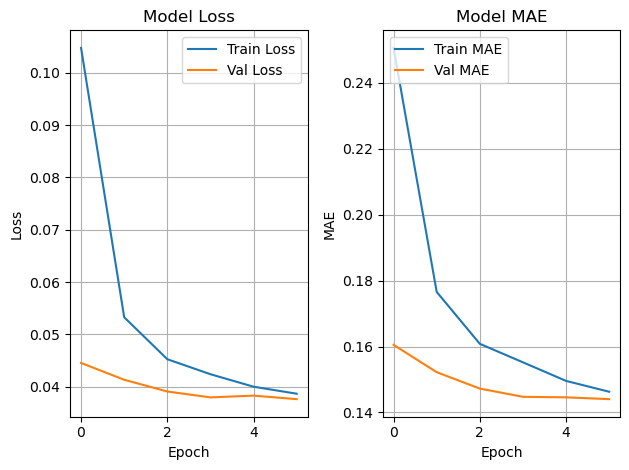

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()




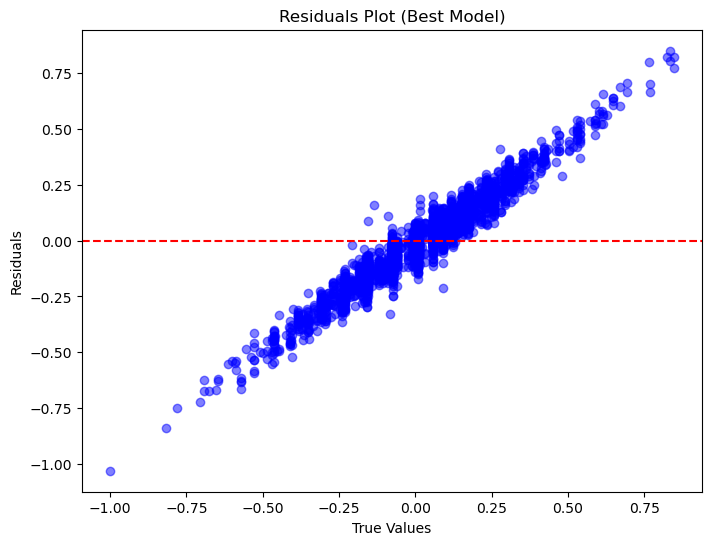

In [20]:
# Function to plot residuals
def plot_residuals(y_true, y_pred, title="Residuals Plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, residuals, color='blue', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.show()

# Plot residuals for the test set
plot_residuals(y_test.to_numpy(), y_pred, title="Residuals Plot (Best Model)")